# 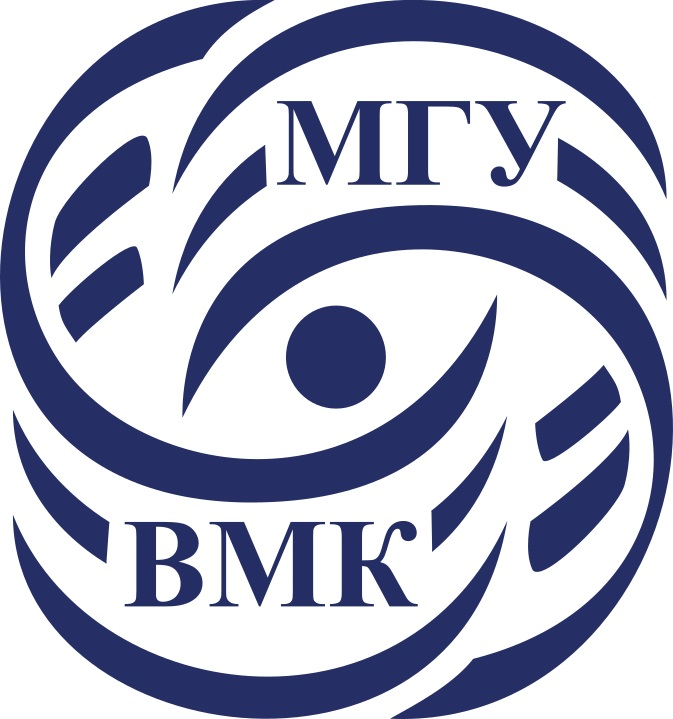

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.52MB/s]


Проверим версию библиотеки:

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [ ]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [ ]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [ ]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder contents


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: /content/05-SVM/imbalanced/X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 3.19MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: /content/05-SVM/imbalanced/X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 5.17MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: /content/05-SVM/imbalanced/y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 3.13MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: /content/05-SVM/imbalanced/y_imb.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5
To: /content/05-SVM/public/cX_test.npy
100%|██████████| 8.13k/8

['/content/05-SVM/imbalanced/X_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/X_imb.npz.npy',
 '/content/05-SVM/imbalanced/y_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/y_imb.npz.npy',
 '/content/05-SVM/public/cX_test.npy',
 '/content/05-SVM/public/cX_train.npy',
 '/content/05-SVM/public/cy_train.npy']

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [ ]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

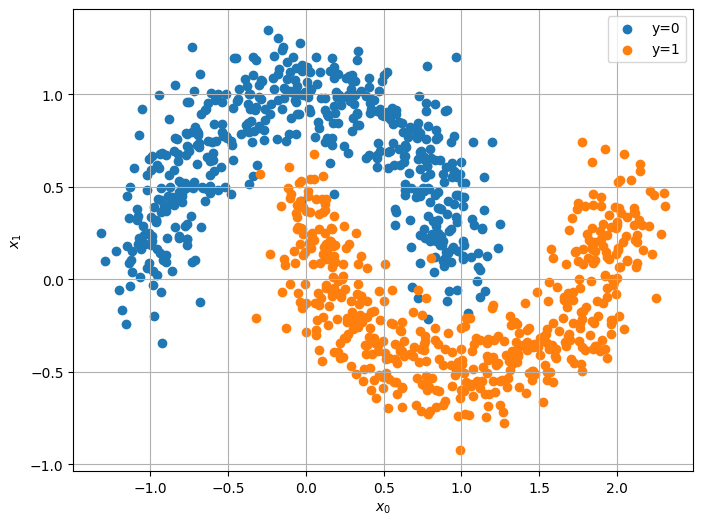

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

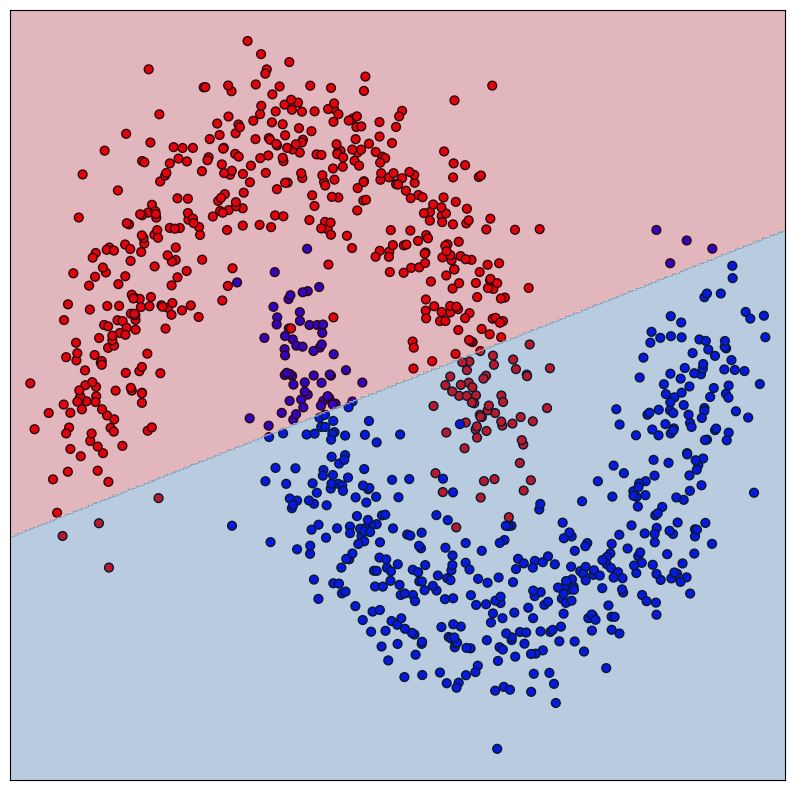

Train Accuracy (linear): 0.875


In [ ]:
linear_svc.fit(X, y)
plot_separating_surface(X, y, linear_svc)
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

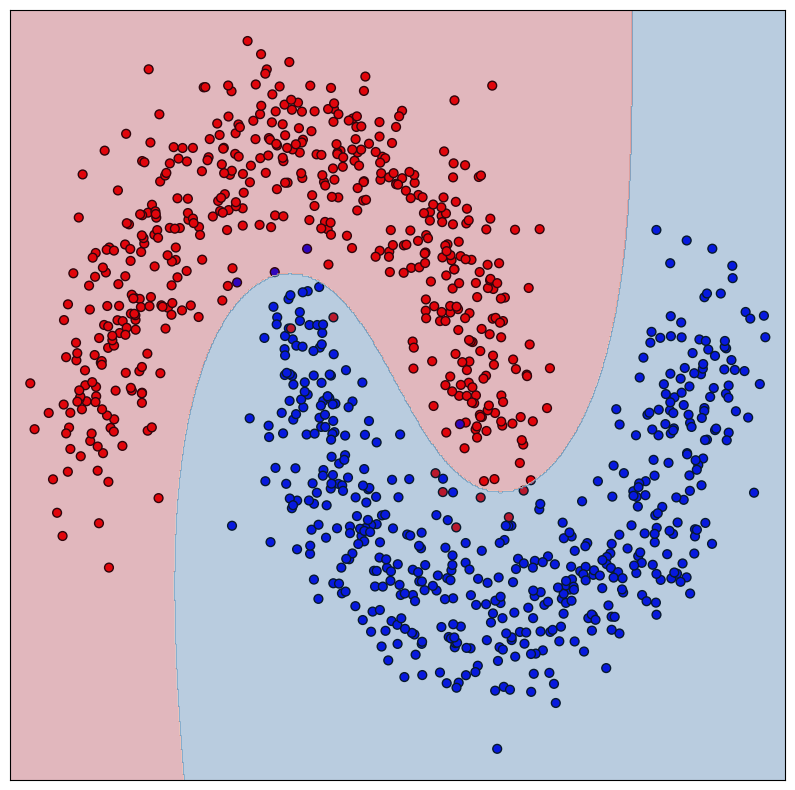

Train Accuracy (non linear): 0.988


In [ ]:
nonlinear_svc.fit(X, y)
plot_separating_surface(X, y, nonlinear_svc)
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Модель с RBF ядром подходит лучше, потому что классы линейно неразделимы. Это ясно визуально и по accuracy.

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

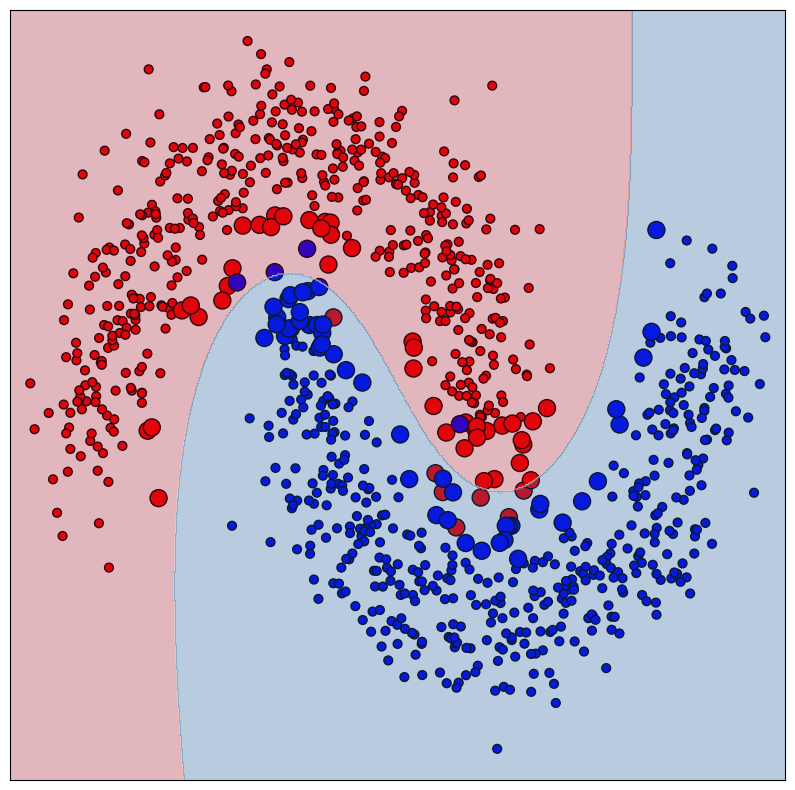

In [ ]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [ ]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

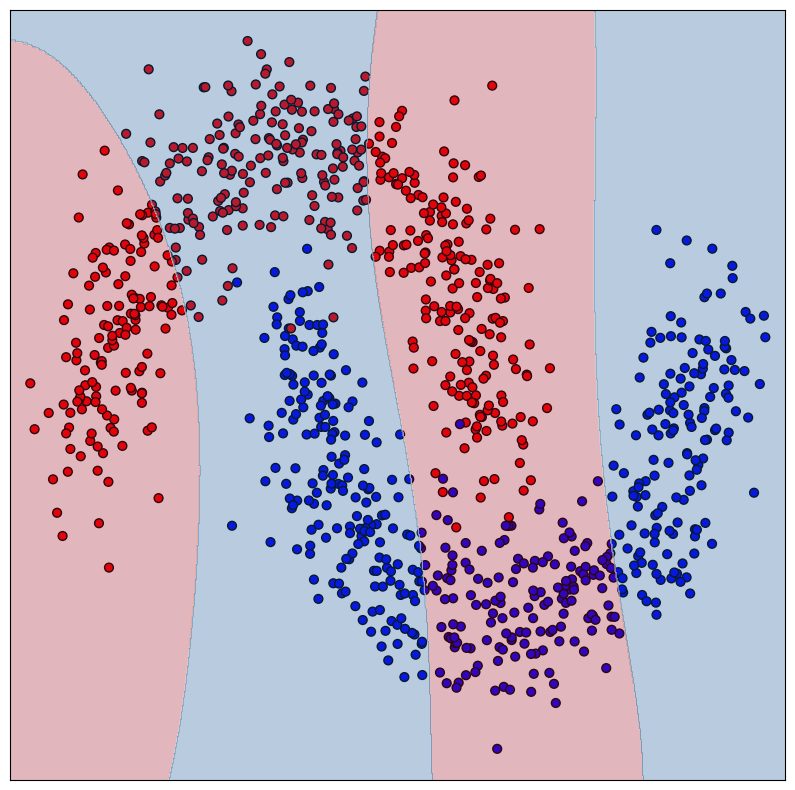

In [ ]:
plot_separating_surface(X, y, svc_on_linear_support)

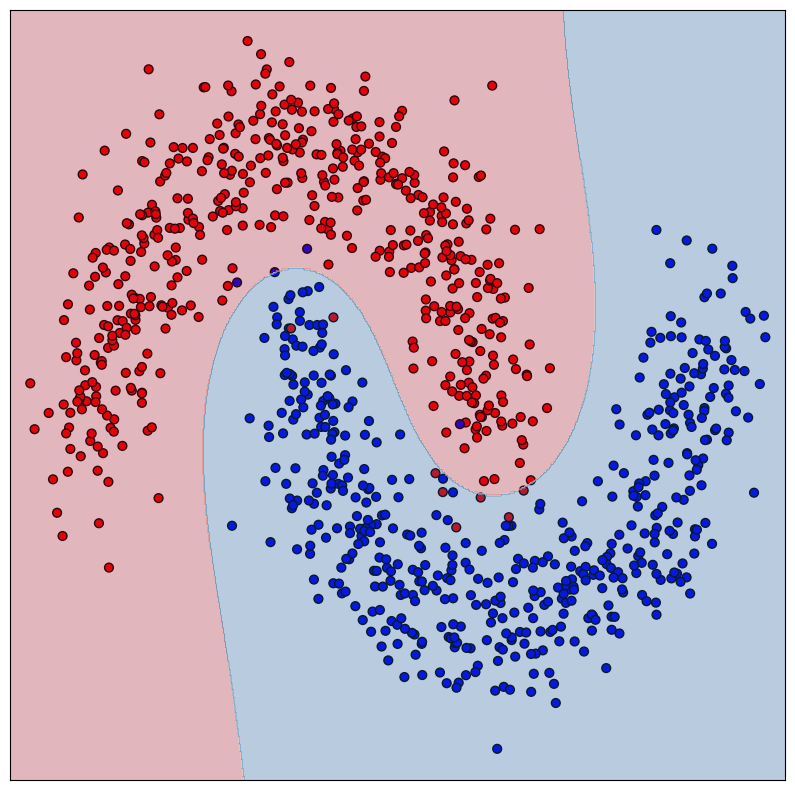

In [ ]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

На нелинейную модель больше похожа вторая поверхность.

Опорные векторы, полученные из линейной модели, могут не отражать более сложные зависимости данных. Используя RBF-ядро, модель svc_on_linear_support может пытаться учесть нелинейные зависимости, но она ограничена теми опорными векторами, которые были выбраны линейной моделью.

Нелинейная модель уже учитывает сложные зависимости и структуры данных, поэтому опорные векторы, которые она определяет, лучше отражают границы между классами. Соответственно поскольку модель svc_on_rbf_support использует те же опорные векторы, что и исходная нелинейная модель, она более точно воспроизводит форму разделяющей поверхности и структуру классов.



---

Теперь обучим модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [ ]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

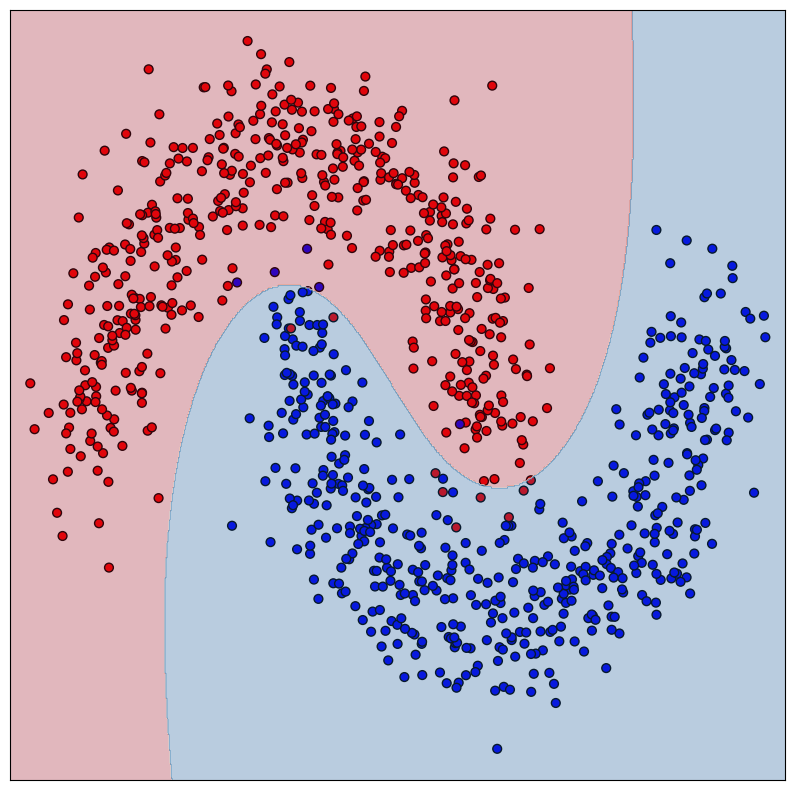

In [ ]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

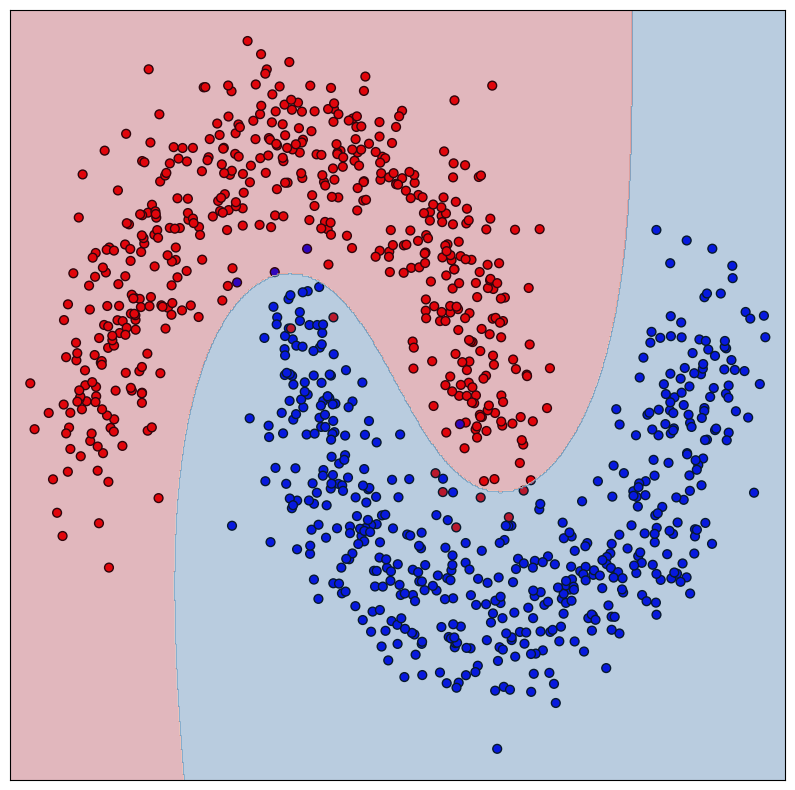

In [ ]:
plot_separating_surface(X, y, nonlinear_svc)

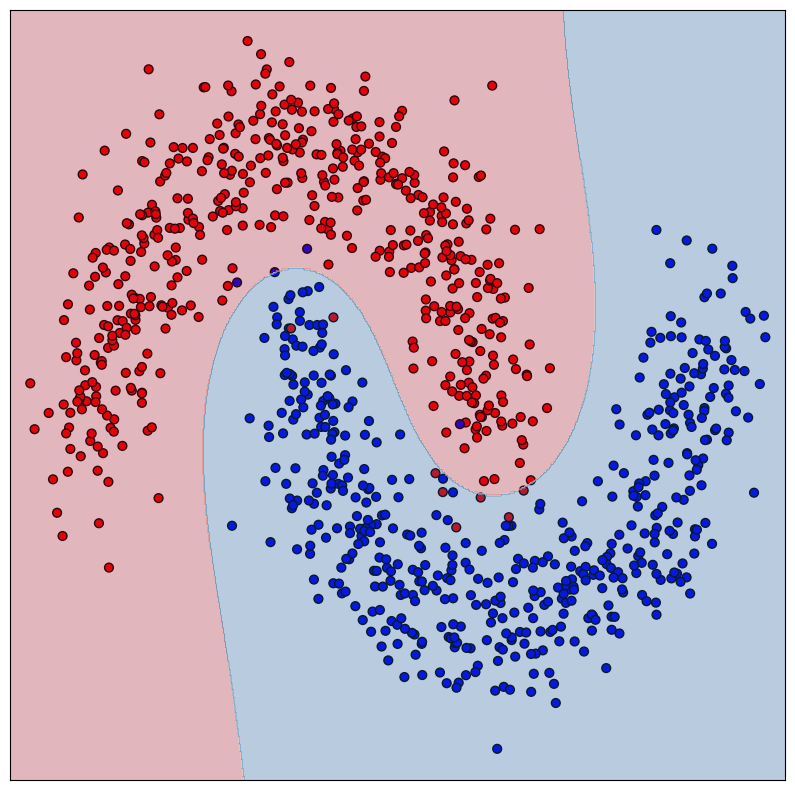

In [ ]:
plot_separating_surface(X, y, svc_on_rbf_support)

In [ ]:
print(f'Train Accuracy (svc all without rbf support): {accuracy_score(y, svc_all_without_rbf_support.predict(X)):.3f}')
print(f'Train Accuracy (svc on rbf support): {accuracy_score(y, svc_on_rbf_support.predict(X)):.3f}')
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

Train Accuracy (svc all without rbf support): 0.986
Train Accuracy (svc on rbf support): 0.988
Train Accuracy (non linear): 0.988


### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Полученные разделяющие поверхности практически не различаются.

Модель svc_on_rbf_support допускает чуть меньше ошибок на граничных объектах, чем nonlinear_svc. А nonlinear_svc меньше, чем svc_all_without_rbf_support.

Мы удалили старые опорные векторы, и моделью были выбраны другие опорные объекты и векторы. В общем случае новые опорные векторы могут отличаться от старых (их выбор будет зависеть от структуры оставшихся данных), и это может привести к изменению формы разделяющей поверхности и изменению качества классификации.

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [ ]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [ ]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [ ]:
X = X_train
y = y_train.ravel()

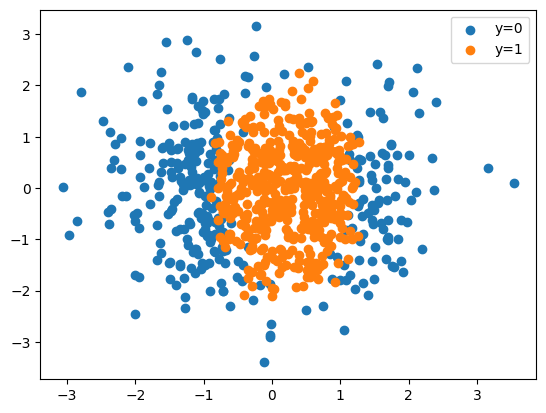

In [ ]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
total_samples = len(y_train)

for class_label, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f"Class {class_label}: {count} examples ({percentage:.2f}%)")

Class 0.0: 318 examples (39.75%)
Class 1.0: 482 examples (60.25%)


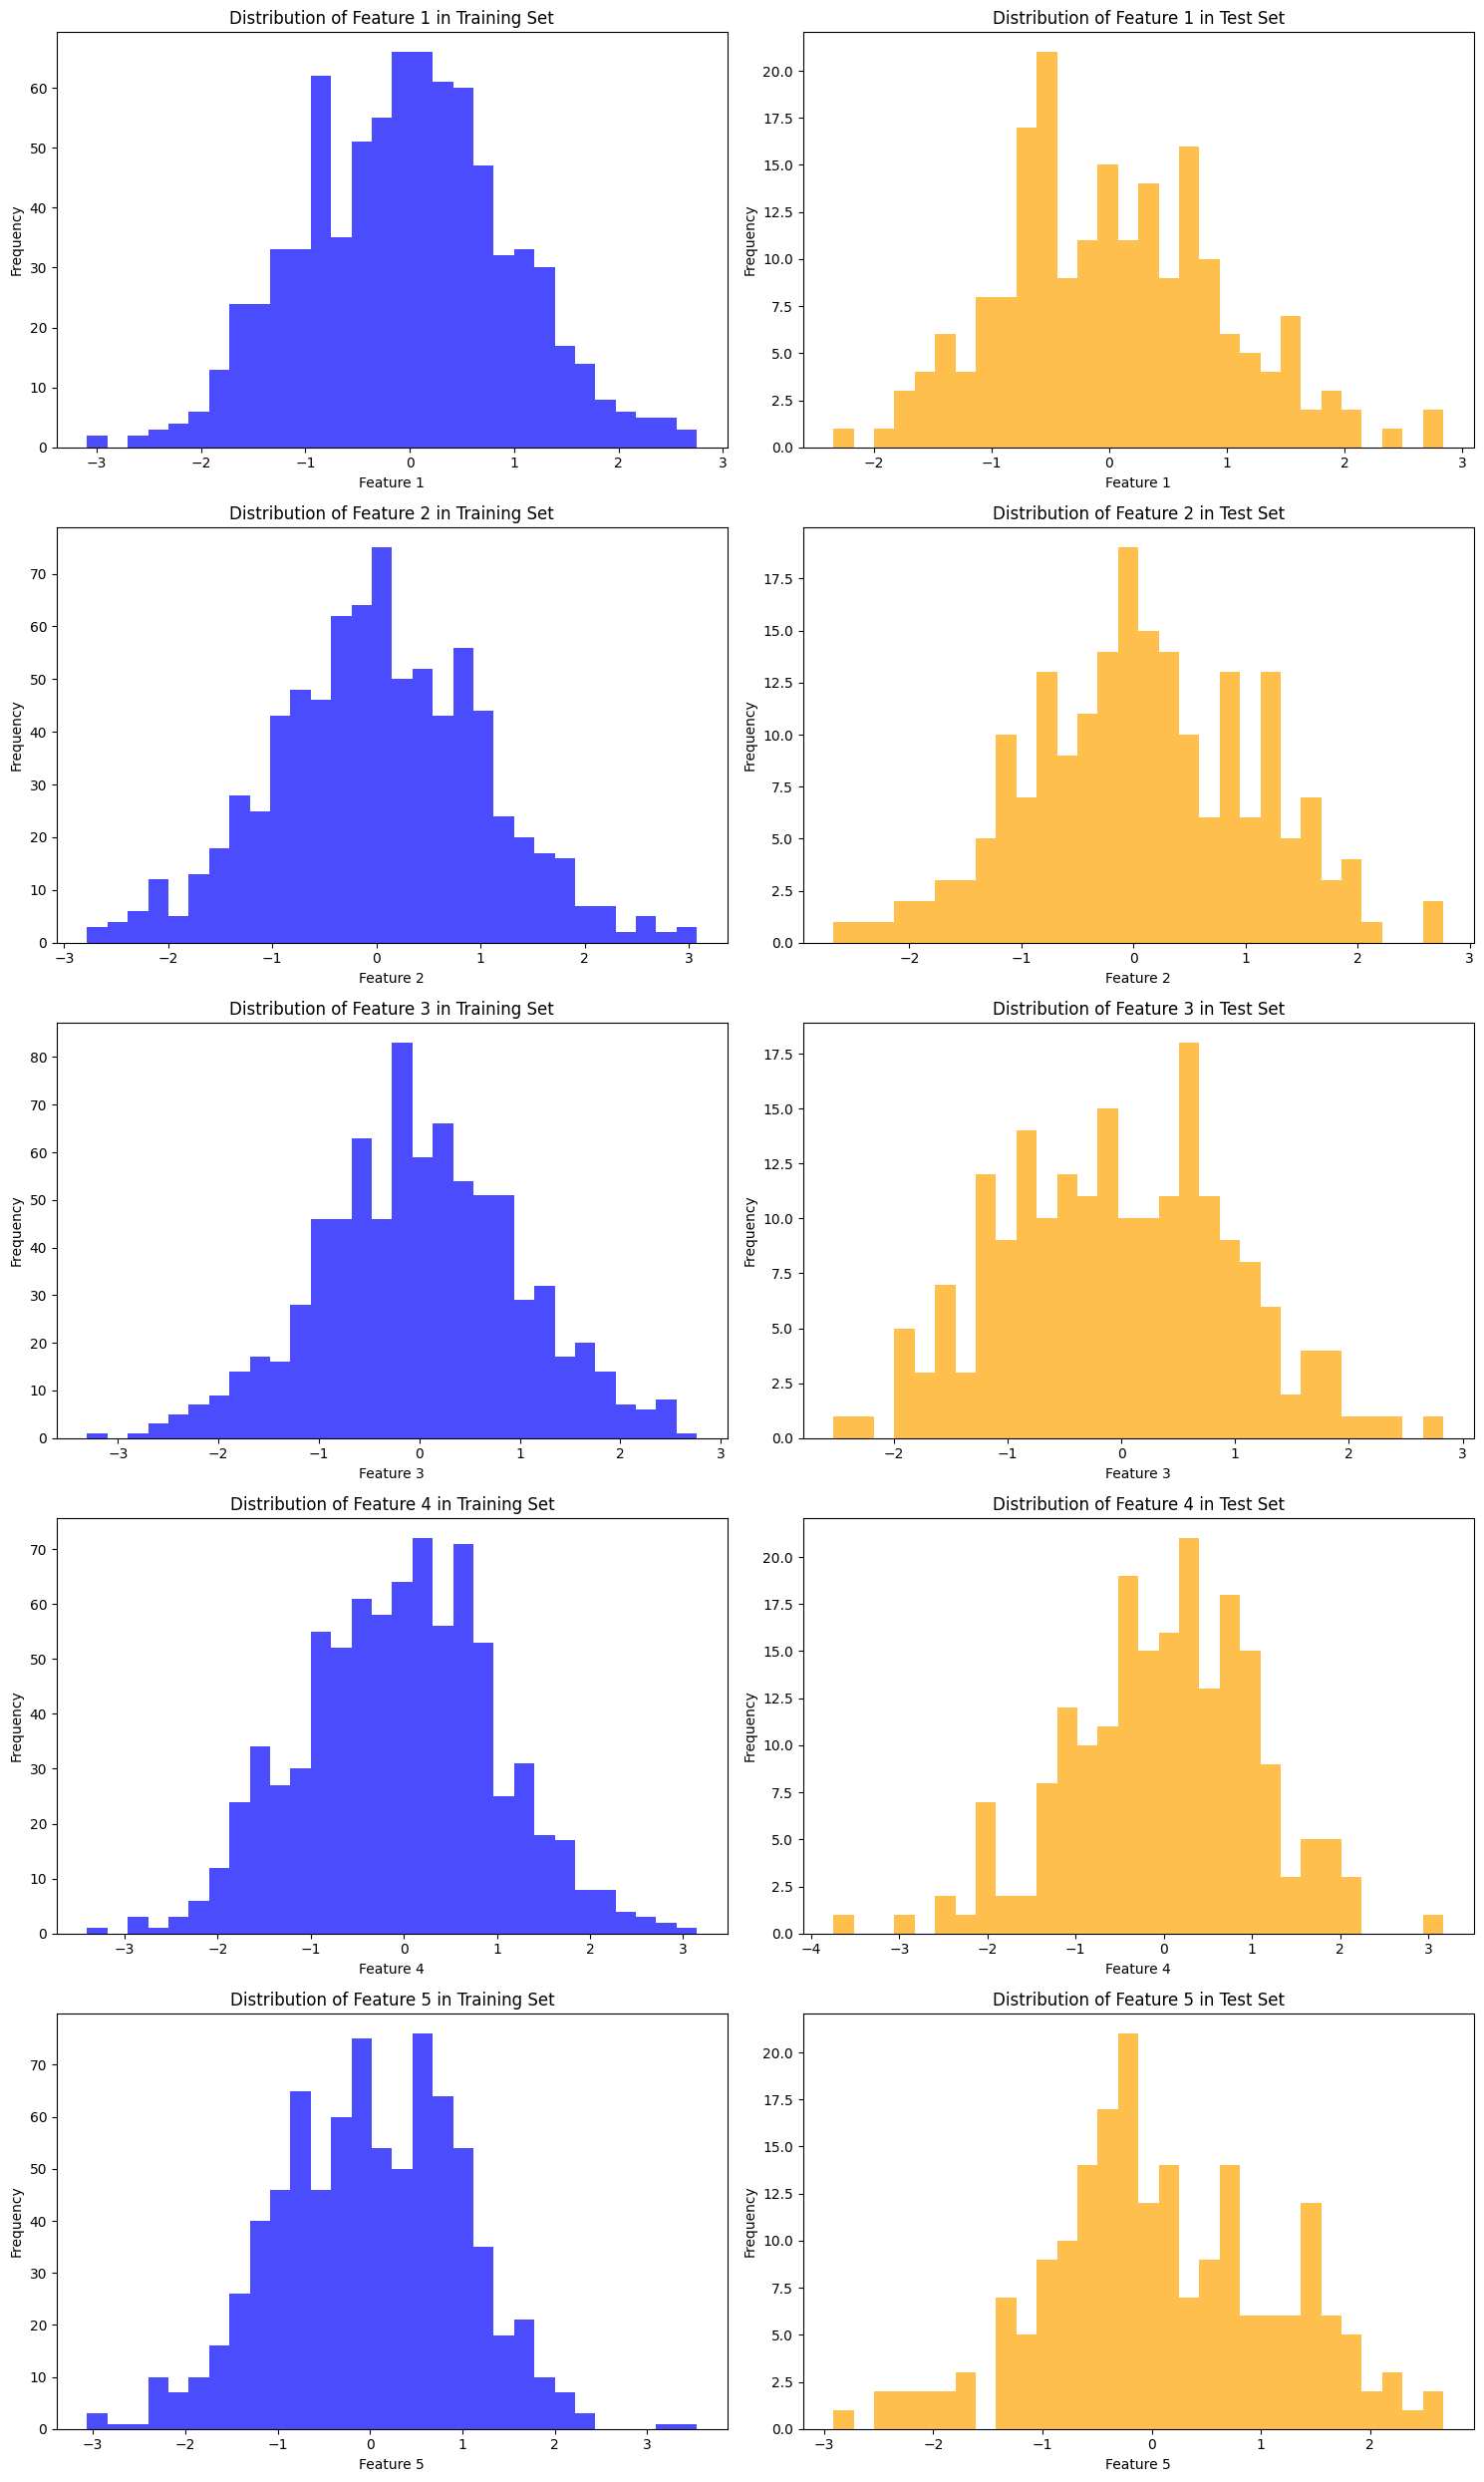

In [ ]:
X_train = np.load('05-SVM/public/cX_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

num_features = X_train.shape[1]

plt.figure(figsize=(15, 5 * num_features))

for i in range(num_features):
    plt.subplot(num_features, 2, 2 * i + 1)
    plt.hist(X_train[:, i], bins=30, alpha=0.7, label='Train', color='blue')
    plt.title(f'Distribution of Feature {i + 1} in Training Set')
    plt.xlabel(f'Feature {i + 1}')
    plt.ylabel('Frequency')

    plt.subplot(num_features, 2, 2 * i + 2)
    plt.hist(X_test[:, i], bins=30, alpha=0.7, label='Test', color='orange')
    plt.title(f'Distribution of Feature {i + 1} in Test Set')
    plt.xlabel(f'Feature {i + 1}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
train_df = pd.DataFrame(X_train, columns=[f'Feature {i+1}' for i in range(X_train.shape[1])])
test_df = pd.DataFrame(X_test, columns=[f'Feature {i+1}' for i in range(X_test.shape[1])])

def print_statistics(train_df, test_df):
    print("Statistics for Training Set:")
    print(train_df.describe())
    print("\nStatistics for Test Set:")
    print(test_df.describe())

print_statistics(train_df, test_df)

Statistics for Training Set:
        Feature 1   Feature 2   Feature 3   Feature 4   Feature 5
count  800.000000  800.000000  800.000000  800.000000  800.000000
mean    -0.035549    0.031240    0.007364   -0.049768   -0.003901
std      0.988102    1.017274    1.000957    1.028088    0.995670
min     -3.089807   -2.777415   -3.305221   -3.403146   -3.061762
25%     -0.767449   -0.653557   -0.634851   -0.743408   -0.731588
50%      0.005393    0.005682   -0.004086    0.003027    0.004338
75%      0.609065    0.743035    0.672630    0.647665    0.719216
max      2.750770    3.078693    2.761575    3.149742    3.537968

Statistics for Test Set:
        Feature 1   Feature 2   Feature 3   Feature 4   Feature 5
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean     0.037944    0.070573   -0.043033   -0.004682    0.078786
std      0.952577    1.008879    1.007323    1.071641    1.071610
min     -2.340580   -2.676000   -2.530791   -3.747956   -2.912985
25%     -0.623666   -

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

X = np.load('05-SVM/public/cX_train.npy')
y = np.load('05-SVM/public/cy_train.npy')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = [
    {
        'C': [0.01, 0.1, 1, 2, 10, 100],
        'kernel': ['linear'],
    },
    {
        'C': [0.01, 0.1, 1, 2, 10, 100],
        'kernel': ['rbf'],
    },
    {
        'C': [0.01, 0.1, 1, 2, 10, 100],
        'kernel': ['poly'],
        'degree': [2, 3, 4],
    }
]

model = SVC(class_weight='balanced')

stratified_kf = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(model, param_grid, cv=stratified_kf)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

y_train_pred = best_model.predict(X_scaled)
print("Train Accuracy:", accuracy_score(y, y_train_pred))
print(classification_report(y, y_train_pred))


Best parameters: {'C': 1, 'kernel': 'rbf'}
Train Accuracy: 0.9525
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       318
         1.0       0.96      0.96      0.96       482

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



In [ ]:
results = grid_search.cv_results_

results_df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None)

print("\nAll results from GridSearchCV:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])


All results from GridSearchCV:
                                        params  mean_test_score  \
0              {'C': 0.01, 'kernel': 'linear'}          0.74000   
1               {'C': 0.1, 'kernel': 'linear'}          0.72625   
2                 {'C': 1, 'kernel': 'linear'}          0.73250   
3                 {'C': 2, 'kernel': 'linear'}          0.73250   
4                {'C': 10, 'kernel': 'linear'}          0.73250   
5               {'C': 100, 'kernel': 'linear'}          0.73250   
6                 {'C': 0.01, 'kernel': 'rbf'}          0.45500   
7                  {'C': 0.1, 'kernel': 'rbf'}          0.87875   
8                    {'C': 1, 'kernel': 'rbf'}          0.92125   
9                    {'C': 2, 'kernel': 'rbf'}          0.91875   
10                  {'C': 10, 'kernel': 'rbf'}          0.91875   
11                 {'C': 100, 'kernel': 'rbf'}          0.91375   
12  {'C': 0.01, 'degree': 2, 'kernel': 'poly'}          0.66250   
13  {'C': 0.01, 'degree': 3, '

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = np.load('05-SVM/public/cX_train.npy')
y = np.load('05-SVM/public/cy_train.npy')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'penalty': ['l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'penalty': ['l1', 'l2']
    }
]

model = LogisticRegression(max_iter=1000)

stratified_kf = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(model, param_grid, cv=stratified_kf)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

y_train_pred = best_model.predict(X_scaled)
print("Train Accuracy:", accuracy_score(y, y_train_pred))
print(classification_report(y, y_train_pred))


Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train Accuracy: 0.82
              precision    recall  f1-score   support

         0.0       0.92      0.60      0.73       318
         1.0       0.78      0.97      0.87       482

    accuracy                           0.82       800
   macro avg       0.85      0.78      0.80       800
weighted avg       0.84      0.82      0.81       800



In [ ]:
results = grid_search.cv_results_

results_df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None)

print("\nAll results from GridSearchCV:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])


All results from GridSearchCV:
                                                 params  mean_test_score  \
0   {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}          0.51875   
1   {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}          0.78625   
2    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}          0.80500   
3    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}          0.79500   
4      {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}          0.79750   
5      {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}          0.79625   
6     {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}          0.79625   
7     {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}          0.79625   
8    {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}          0.79625   
9    {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}          0.79625   
10      {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}          0.72875   
11       {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'} 

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

**Общий вывод:**

Выбор гиперпараметров заметно влияет на качество SVM модели, но слабо влияет на качество линейной модели.

**SVM**

Модель SVM с параметрами {'C': 1, 'kernel': 'rbf'} показала высокую производительность с точностью 95.25%. Использование RBF ядра позволило модели улавливать нелинейные зависимости в данных, что улучшило показатели precision и recall для обоих классов. При этом SVM продемонстрировала сбалансированные значения этих метрик.

Выбор параметра C также оказал влияние на производительность модели. В рамках эксперимента изменение значения C от 0.01 до 100 показало, что значение C=1 обеспечило оптимальный баланс.

Результаты с линейным ядром были значительно ниже (например, максимальный mean_test_score составил 0.74000), что подтверждает, что RBF ядро лучше подходит для данной задачи.

**Логистическая регрессия**

Логистическая регрессия показала приемлемые результаты с наилучшими параметрами {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, обеспечив точность 82%. Однако recall для класса 0 составил только 60%, в то время как для класса 1 он достиг 97%.

Параметр регуляризации C также оказал влияние на производительность модели. Значение C=0.1 обеспечило хорошую обобщающую способность, но все же не смогло достичь уровня точности SVM с RBF ядром.

**Scaler**

Применение StandardScaler для нормализации признаков помогло улучшить сходимость алгоритмов и повысить стабильность моделей, особенно для SVM, который чувствителен к масштабу данных.

**Итог**

Модель SVM с RBF ядром является более подходящим выбором для данной задачи.

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

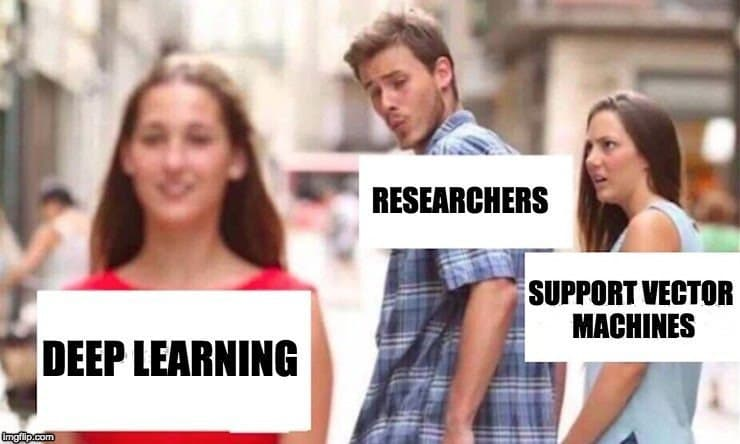

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

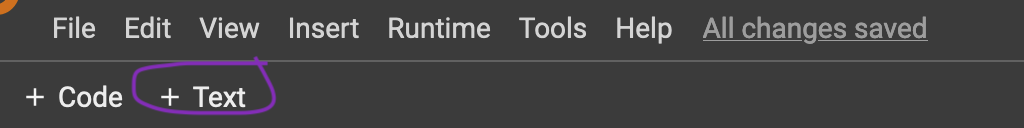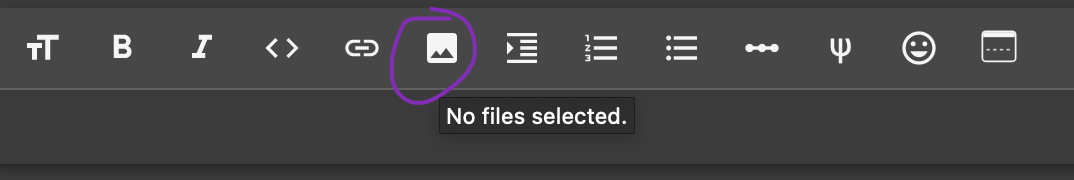

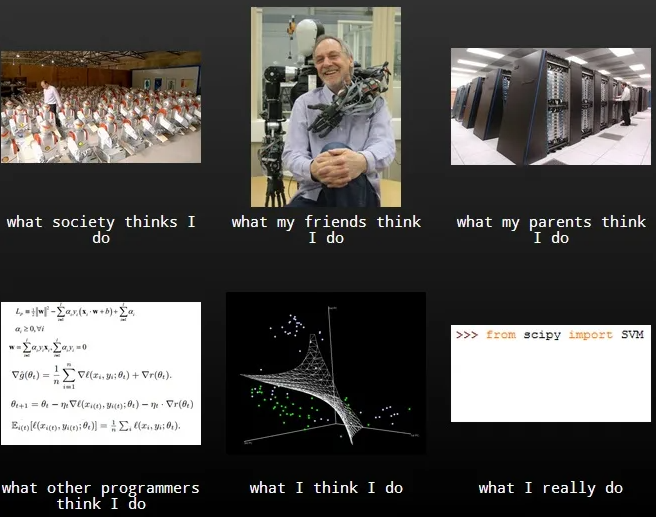